In [2]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [3]:
# M/D/1 queue

import scipy.stats as sts
import numpy as np


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [4]:
# Run a short test
bus_system = run_simulation(arrival_rate=1.2, service_rate=1, run_until=100)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 18 people in the queue


The average number of people in queue: 1.71
Standard error of the mean: 0.23194173772085458
95% confidence interval of population mean: [2.164605805932875, 1.255394194067125]


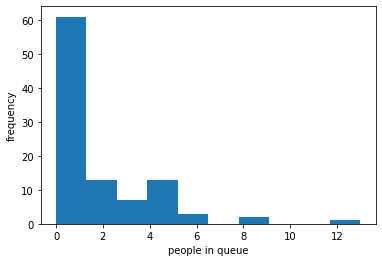

In [14]:
import matplotlib.pyplot as plt # import matplot to plot data

# store the result to plot histogram
result_experiment_1 = []

N_1 = 100 #test with 100 trials

for i in range(N_1):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    result_experiment_1.append(bus_system.queue.people_in_queue)

plt.hist(result_experiment_1)
plt.xlabel('people in queue') # Label the horizontal axis
plt.ylabel('frequency') # Label the vertical axis

m_1 = np.mean(result_experiment_1)
print('The average number of people in queue:', m_1)

t_1 = sts.sem(result_experiment_1)
print('Standard error of the mean:', t_1)
print('95% confidence interval of population mean:', [m_1 + 1.96*t_1, m_1 - 1.96*t_1])

plt.show()

No handles with labels found to put in legend.


The average number of people in queue: 1.4
Standard error of the mean: 0.06905627247954216
95% confidence interval of population mean: [1.7353502940599026, 1.4646497059400976]


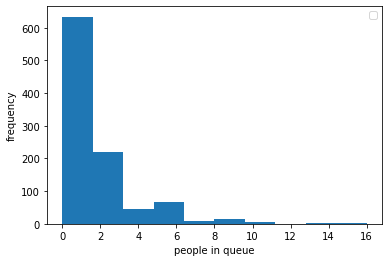

In [10]:
# store the result to plot histogram
result_experiment_2 = []

N_2 = 1000 #test with 100 trials

for i in range(N_2):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    result_experiment_2.append(bus_system.queue.people_in_queue)

plt.hist(result_experiment_2)
plt.xlabel('people in queue') # Label the horizontal axis
plt.ylabel('frequency') # Label the vertical axis
plt.legend() # Display the labels on the plot

m_2 = np.mean(result_experiment_2)
print('The average number of people in queue:', m_1)

t_2 = sts.sem(result_experiment_2)
print('Standard error of the mean:', t_2)
print('95% confidence interval of population mean:', [m_2 + 1.96*t_2, m_2 - 1.96*t_2])

plt.show()

### Comparison between two experiments

By observation, I saw that:
- The shape of distributions between 2 experiments is not different. They are exponetial distribution with high frequency in smaller values and get smaller frequency in large values.
- The average queue lengths (the mean) are the same in both experiments (mean = 1.4 people)
- However, by increasing the number of trials, the confident interval in the second experiment is narrower than the confident interval in the first experiment. 

### Experiments for different values of the arrival rate

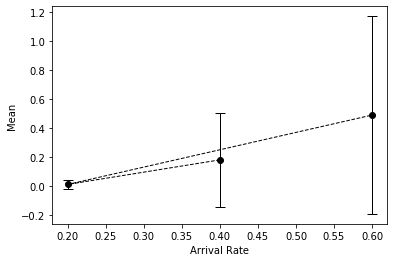

In [13]:
arrival_rate_list = [0.4,0.2,0.6]
mean_list = []
confident_interval_list = []

#first test with arrival rate = 0.4
result_exp_1 = []
for i in range(100):
    bus_system = run_simulation(arrival_rate=0.4, service_rate=1, run_until=100)
    result_exp_1.append(bus_system.queue.people_in_queue)

mean_list.append(np.mean(result_exp_1))
confident_interval_list.append(np.mean(result_exp_1)+1.96*sts.sem(result_exp_1))

#second test with arrival rate = 0.2
result_exp_2 = []
for i in range(100):
    bus_system = run_simulation(arrival_rate=0.2, service_rate=1, run_until=100)
    result_exp_2.append(bus_system.queue.people_in_queue)

mean_list.append(np.mean(result_exp_2))
confident_interval_list.append(np.mean(result_exp_2)+1.96*sts.sem(result_exp_2))

#third test with arrival rate = 0.6
result_exp_3 = []
for i in range(100):
    bus_system = run_simulation(arrival_rate=0.6, service_rate=1, run_until=100)
    result_exp_3.append(bus_system.queue.people_in_queue)

mean_list.append(np.mean(result_exp_3))
confident_interval_list.append(np.mean(result_exp_3)+1.96*sts.sem(result_exp_3))

plt.figure()
plt.xlabel('Arrival Rate')
plt.ylabel('Mean')
plt.errorbar(arrival_rate_list, mean_list, confident_interval_list, color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.show()


### Reflection

I used #EmpiricalAnalysis in this pre-class work by running many experiments with different numbers of trials, different arrival rates, different service rates to capture the differences in the results and the effects of each factor in the results. I also created visualizations with different types of plots (histogram and error bars). I also tried to create comparisons in results between experiments and understand why they happen. 

I used #Professionalism by creating good-looking visualization, clean code with well-organized comments, adding labals to the plots.